(256, 512, 3) uint8 255 86


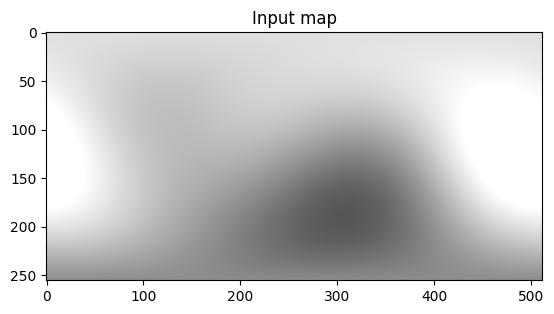

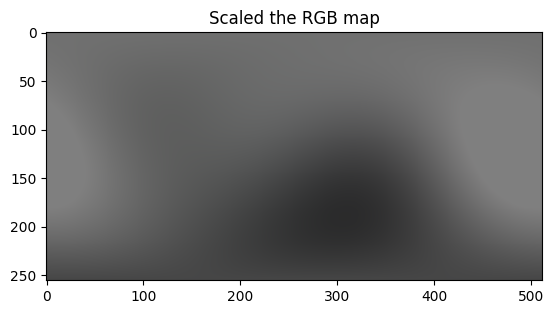

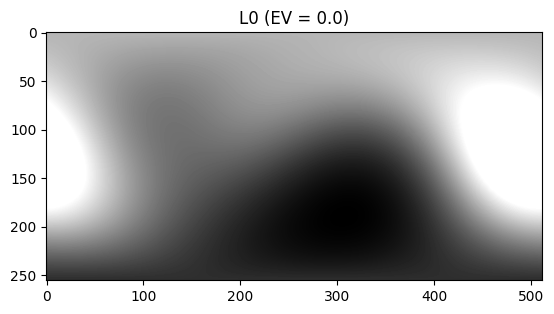

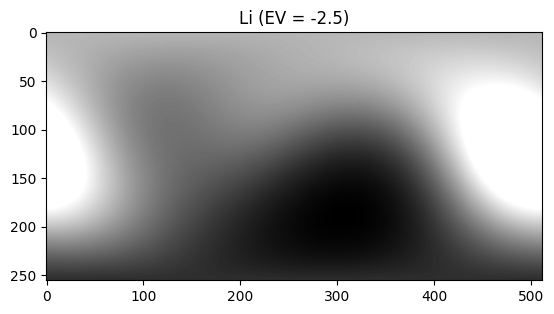

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [13.17085393668526..20.71562245442966].


1442.497833620557 486.4894654563447
20.71562245442966 13.17085393668526


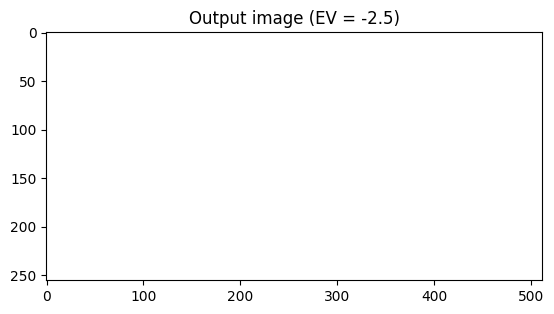

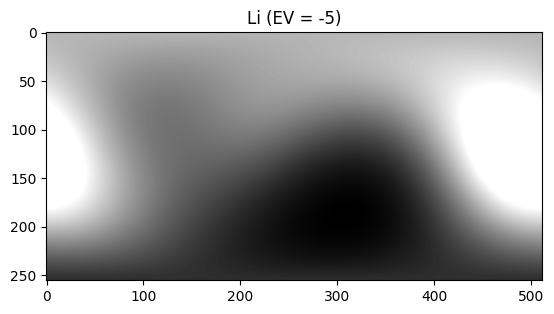

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [27.11357883106976..42.64527305161319].


8160.0 2752.0
42.64527305161319 27.11357883106976


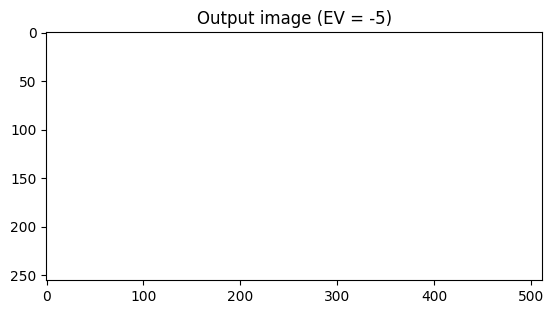

In [ ]:
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt

input_map_paths = '/data/mint/DPM_Dataset/Dataset_For_Baseline/Dataset_For_Baseline_Submit/ffhq_rotate/valid/pair57_src=69757.jpg_dst=60000.jpg/n_step=60/map_clean/'
input_map_paths = sorted(glob.glob(input_map_paths + '*.png'))

def getLuminance(image, ev, gamma=2.4):
    image = image / 255.0
    image = image ** gamma
    luminance_image = np.sum(image * np.array([0.21267, 0.71516, 0.07217])[None, None, :], axis=-1)
    luminance_image = luminance_image * (2 ** (-ev))
    return luminance_image


def getHDR(image, ev, gamma=2.4):
    image = image / 255.0
    image = image ** gamma
    luminance_image = np.sum(image * np.array([0.21267, 0.71516, 0.07217])[None, None, :], axis=-1)
    luminance_image = luminance_image * (2 ** (-ev))
    rgb = image * (luminance_image[..., None] / (luminance_image[..., None] + 1))
    rgb = rgb ** (1.0 / gamma)
    return rgb, luminance_image

gamma = 2.4

def proc(path):
    map = np.array(Image.open(path))    # (256, 512, 3); uint8
    map_adjusted = (map * 0.5)
    print(map.shape, map.dtype, np.max(map), np.min(map))
    plt.imshow(map)
    plt.title("Input map")
    plt.show()
    plt.imshow(np.clip(map_adjusted, 0, 255).astype(np.uint8))
    plt.title("Scaled the RGB map")
    plt.show()
    
    # Scaled the luminance instead of RGB to make it sensible
    L0 = getLuminance(map.copy(), ev=0.0)
    plt.imshow(L0, cmap='gray')
    plt.title(f"L0 (EV = {0.0})")
    plt.show()
        
    for ev in [-2.5, -5]:
        Li = (getLuminance(map.copy(), ev=ev))
        plt.imshow(Li, cmap='gray')
        plt.title(f"Li (EV = {ev})")
        plt.show()
        
        out_image = map.copy() * (Li / L0)[..., None]
        print(np.max(out_image), np.min(out_image))
        out_image_gamma_corrected = out_image.copy() ** (1.0 / gamma)
        print(np.max(out_image_gamma_corrected), np.min(out_image_gamma_corrected))
        plt.imshow(out_image_gamma_corrected)
        plt.title(f"Output image (EV = {ev})")
        plt.show()
        
proc(input_map_paths[0])

(256, 512, 3) uint8 255 86


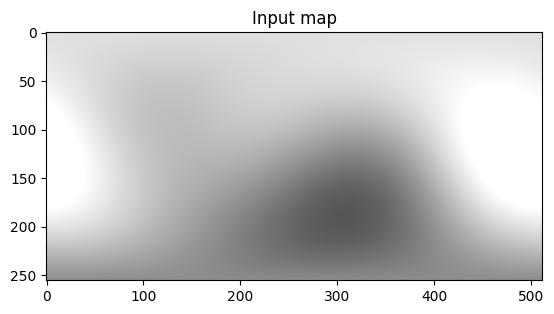

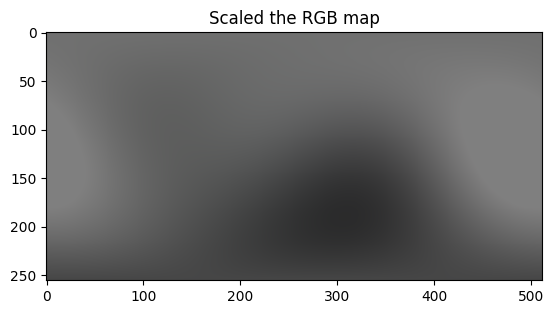

0.23296241426150371 2.748989304248532e-05


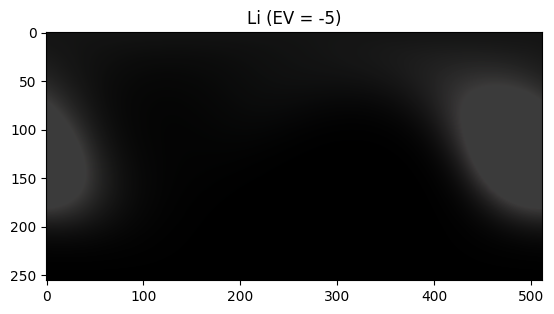

0.4003123183920009 4.898142094603705e-05


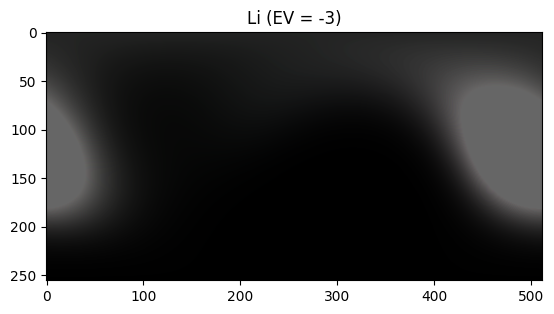

0.632702393224493 8.727497026209188e-05


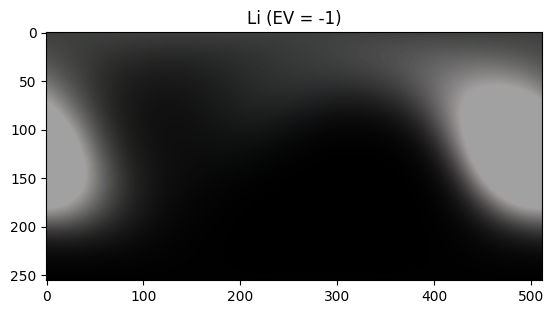

0.6926440870708217 0.00010083337225860207


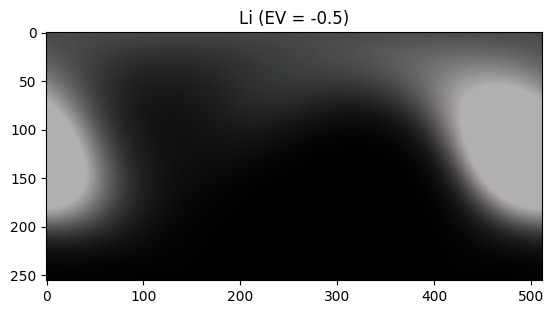

0.7382283555631584 0.000113181633559471


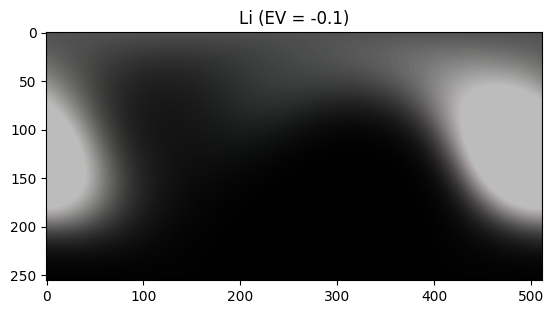

0.759860097534806 0.00011991176371304502


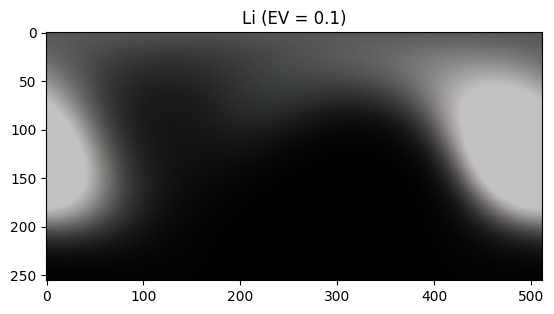

0.8002482139699074 0.00013459640390677465


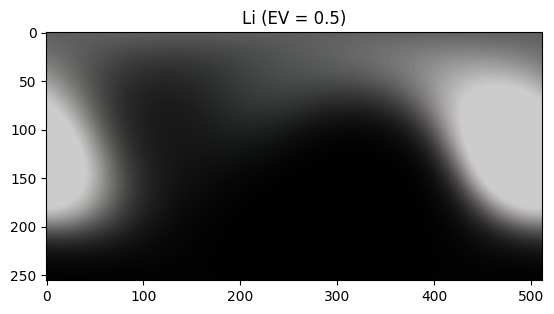

0.8445563703048139 0.00015550631822924745


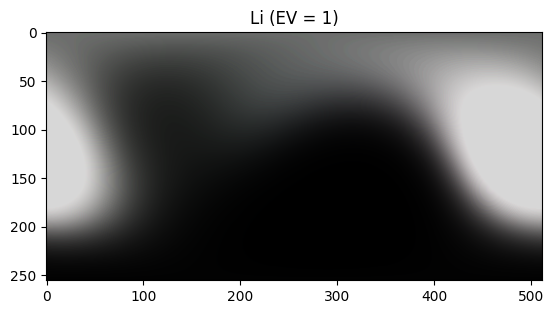

0.9521085145100042 0.0002770807588952985


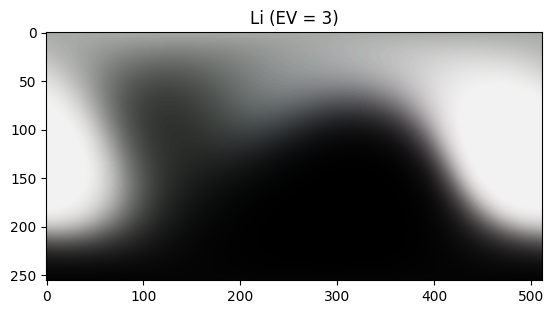

0.987260321131619 0.0004937017840532668


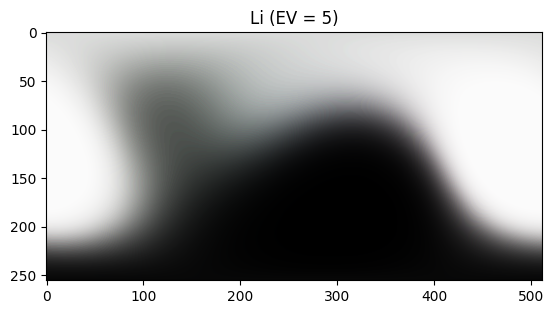

In [6]:
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt

input_map_paths = '/data/mint/DPM_Dataset/Dataset_For_Baseline/Dataset_For_Baseline_Submit/ffhq_rotate/valid/pair57_src=69757.jpg_dst=60000.jpg/n_step=60/map_clean/'
input_map_paths = sorted(glob.glob(input_map_paths + '*.png'))

def getHDR(image, ev, gamma=2.4):
    image_org = image.copy() / 255.0
    # Inverse gamma correction
    image_inv_g = image_org ** 20
    # image_inv_g = image_org ** gamma
    L = np.sum(image_inv_g.copy() * np.array([0.21267, 0.71516, 0.07217])[None, None, :], axis=-1)
    # Adjust exposure
    L_ev = L * (2 ** (ev))
    s = L_ev / (L + 1e-16)
    # Apply to 
    image_out = s[..., None] * image_inv_g
    # Tonemapped & Gamma correction
    image_out_tm = image_out / (image_out + 1)
    image_out_final = image_out_tm ** (1.0 / gamma)
    return image_out_final, L_ev



gamma = 2.4

def proc(path):
    map = np.array(Image.open(path))    # (256, 512, 3); uint8
    map_adjusted = (map * 0.5)
    print(map.shape, map.dtype, np.max(map), np.min(map))
    plt.imshow(map)
    plt.title("Input map")
    plt.show()
    plt.imshow(np.clip(map_adjusted, 0, 255).astype(np.uint8))
    plt.title("Scaled the RGB map")
    plt.show()
        
    for ev in [-5, -3, -1, -0.5, -0.1, 0.1, 0.5, 1, 3, 5]:
        rgb, L = (getHDR(map.copy(), ev=ev))
        print(np.max(rgb), np.min(rgb))
        plt.imshow(rgb)
        plt.title(f"Li (EV = {ev})")
        plt.show()
        
        
proc(input_map_paths[0])

(256, 512, 3) uint8 255 86


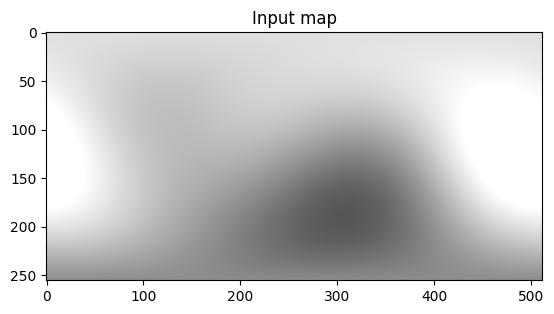

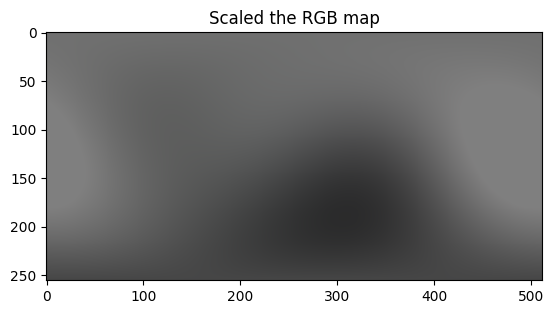

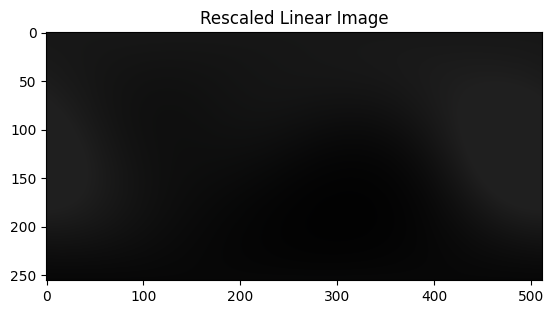

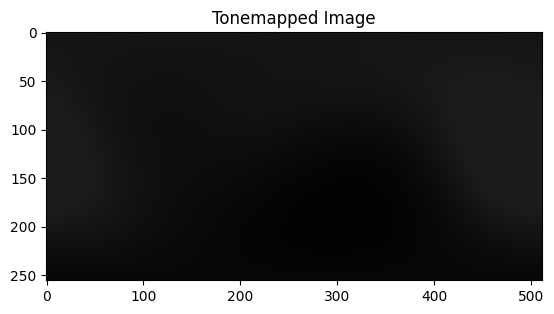

102 36


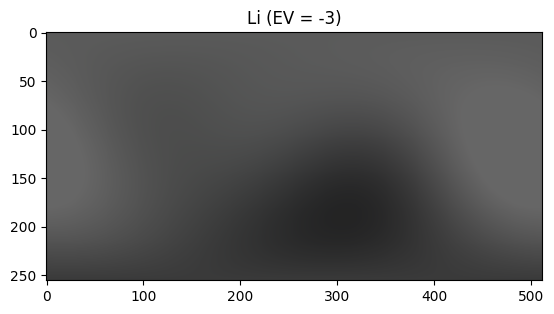

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.5891010245858264..7.999999920000001].


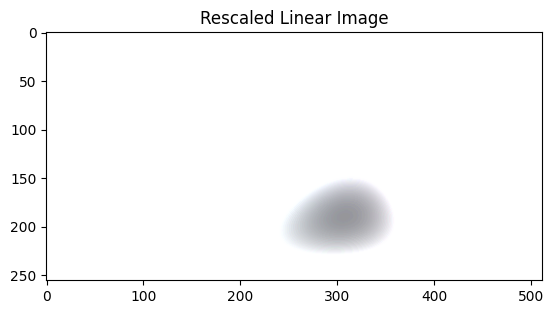

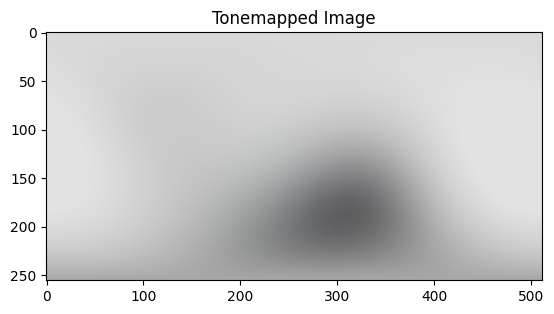

242 168


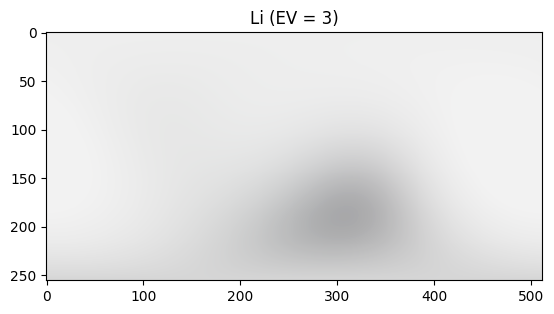

In [31]:
import numpy as np

def get_pseudo_hdr(image, ev, gamma=2.4):
    """
    Adjusts the exposure of a single LDR image to create a pseudo-HDR effect.
    This works by scaling the luminance channel in linear color space.
    """
    # Use a small epsilon to prevent division by zero in black areas
    epsilon = 1e-8
    
    # 1. Normalize and convert to linear space (inverse gamma)
    image_linear = (image / 255.0) ** gamma
    
    # 2. Define RGB-to-Luminance weights (BT.709 standard)
    lum_weights = np.array([0.2126, 0.7152, 0.0722])
    
    # 3. Separate Luminance from Chrominance (color)
    # Calculate luminance and add a new axis for broadcasting
    luminance = np.sum(image_linear * lum_weights, axis=-1, keepdims=True)
    
    # The original color is the image divided by its luminance
    chrominance = image_linear / (luminance + epsilon)
    
    # 4. Scale the luminance with the exposure value
    luminance_scaled = luminance * (2 ** ev)
    
    # 5. Recombine the scaled luminance with the original chrominance
    image_rescaled_linear = luminance_scaled * chrominance
    plt.imshow(image_rescaled_linear)
    plt.title("Rescaled Linear Image")
    plt.show()
    
    # 6. Tone map to bring values back into a displayable range (0-1)
    # The Reinhard operator is a simple and effective choice
    image_tonemapped = image_rescaled_linear / (image_rescaled_linear + 1)
    plt.imshow(image_tonemapped)
    plt.title("Tonemapped Image")
    plt.show()
    
    # 7. Apply gamma correction for display
    image_final = image_tonemapped ** (1.0 / gamma)
    
    # Return the final image (scaled to 0-255) and the new luminance map
    return (image_final * 255).astype(np.uint8), luminance_scaled.squeeze()


gamma = 2.4

def proc(path):
    map = np.array(Image.open(path))    # (256, 512, 3); uint8
    map_adjusted = (map * 0.5)
    print(map.shape, map.dtype, np.max(map), np.min(map))
    plt.imshow(map)
    plt.title("Input map")
    plt.show()
    plt.imshow(np.clip(map_adjusted, 0, 255).astype(np.uint8))
    plt.title("Scaled the RGB map")
    plt.show()
        
    # for ev in [-5, -3, -1, -0.5, -0.1, 0.1, 0.5, 1, 3, 5]:
    for ev in [-3, 3]:
        rgb, L = (get_pseudo_hdr(map.copy(), ev=ev))
        print(np.max(rgb), np.min(rgb))
        plt.imshow(rgb)
        plt.title(f"Li (EV = {ev})")
        plt.show()
        
        
proc(input_map_paths[0])

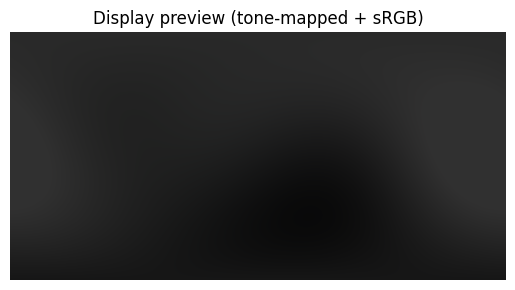

In [37]:
import numpy as np

# sRGB <-> linear helpers (IEC 61966-2-1)
def srgb_to_linear(x):
    x = np.clip(x, 0.0, 1.0)
    a = 0.055
    return np.where(x <= 0.04045, x / 12.92, ((x + a) / (1 + a)) ** 2.4)

def linear_to_srgb(x):
    x = np.maximum(x, 0.0)  # keep positive
    a = 0.055
    return np.where(x <= 0.0031308, 12.92 * x, (1 + a) * (x ** (1/2.4)) - a)

# Rec.709 luminance on *linear* RGB
LUMA = np.array([0.2126, 0.7152, 0.0722], dtype=np.float32)

def rgb_exposure_from_luma(image_uint8, ev, return_hdr=True, safe_eps=1e-6):
    """image_uint8: uint8 RGB in sRGB (0..255). ev: +1 doubles exposure."""
    # 1) normalize to [0,1] and inverse EOTF (linearize)
    srgb = image_uint8.astype(np.float32) / 255.0
    lin  = srgb_to_linear(srgb)

    # 2) compute luminance in linear space
    L = np.tensordot(lin, LUMA, axes=([-1],[0]))  # HxW

    # 3) exposure change (stops)
    L_ev = L * (2.0 ** ev)

    # 4) per-pixel gain; avoid blow-up in dark regions
    gain = L_ev / np.maximum(L, safe_eps)
    # Optionally clamp/soft-limit extreme gains to reduce noise:
    # gain = np.minimum(gain, 16.0)

    # 5) apply gain in linear RGB (preserves chroma under gray-world assumption)
    lin_hdr = lin * gain[..., None]  # <-- HDR *linear* RGB (float)

    if return_hdr:
        # This is your HDR result to SAVE as EXR (no tone map, no gamma)
        hdr_linear = lin_hdr.astype(np.float32)
    else:
        hdr_linear = None

    # 6) Make a display preview (tone-map -> sRGB)
    # Simple Reinhard TM per channel in linear space:
    lin_tm = lin_hdr / (1.0 + lin_hdr)
    disp = np.clip(linear_to_srgb(lin_tm), 0.0, 1.0)

    return hdr_linear, L_ev.astype(np.float32), disp


def proc(path):
    map = np.array(Image.open(path))    # (256, 512, 3); uint8
    hdr_linear, L_ev, preview = rgb_exposure_from_luma(map.copy(), ev=-5)

    # Save HDR:
    # import imageio.v3 as iio
    # iio.imwrite("out.exr", hdr_linear, plugin="TIFF-FI", compression=None)  # or OpenEXR writer

    # Show preview (LDR for your screen):
    import matplotlib.pyplot as plt
    plt.imshow(preview); plt.title("Display preview (tone-mapped + sRGB)"); plt.axis("off")
    plt.show()

proc(input_map_paths[0])

In [ ]:
import numpy as np


def get_hdr(image_uint8, ev):
    image = image_uint8.astype(np.float32) / 255.0
    lumi_scale = np.array([0.212671, 0.715160, 0.072169])
    
    # Inverse gamma correction
    linear_img = image ** 2.4 
    
    # Adjust exposure
    linear_img = linear_img * 1 / (2 ** ev)
    
    lumi_img = linear_img @ lumi_scale  # HxW
    print(lumi_img.shape, linear_img.shape)
    
    # hdr rgb
    hdr_rgb = linear_img * 

    

    return 0


def proc(path):
    map = np.array(Image.open(path))    # (256, 512, 3); uint8
    _ = get_hdr(map.copy(), ev=-5)

    # Save HDR:
    # import imageio.v3 as iio
    # iio.imwrite("out.exr", hdr_linear, plugin="TIFF-FI", compression=None)  # or OpenEXR writer

    # Show preview (LDR for your screen):
    import matplotlib.pyplot as plt

proc(input_map_paths[0])

(256, 512) (256, 512, 3)


In [6]:
from envmap import EnvironmentMap
import skimage
import numpy as np
map_name = "117_hdrmaps_com_free_2K.exr"
hdr_map = f"/home/mint/Dev/DiFaReli++/TPAMI_baseline_MajorRevision/Neural_Gaffer/demo/environment_map_sample/{map_name}"
hdr_image = skimage.io.imread(hdr_map)
hdr_image = skimage.img_as_float(hdr_image)

e = EnvironmentMap(hdr_image, 'latlong')
print(hdr_image.shape)
print(e.data.shape)

np.allclose(e.data, hdr_image)

(512, 1024, 3)
(512, 1024, 3)


True